In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\ncvn\\.cache\\kagglehub\\datasets\\wcukierski\\enron-email-dataset\\versions\\2\\emails.csv")

In [2]:

print(df.head())  
print(df.info()) 
print(df.columns) 

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB
None
Index(['file', 'message'], dtype='object')


In [3]:
df['file'][0]

'allen-p/_sent_mail/1.'

In [4]:
from pprint import pprint
pprint(df['message'][30000])

('Message-ID: <6440303.1075855883977.JavaMail.evans@thyme>\n'
 'Date: Sun, 10 Dec 2000 06:32:00 -0800 (PST)\n'
 'From: veronica.espinoza@enron.com\n'
 'To: debbie.brackett@enron.com, william.bradford@enron.com, \n'
 '\tandrew.conner@enron.com, genia.fitzgerald@enron.com, \n'
 '\tpatrick.hanse@enron.com, kelly.lovvorn@enron.com, \n'
 '\tmelissa.murphy@enron.com, kyle.schultz@enron.com, \n'
 '\tkim.theriot@enron.com, greg.wolfe@enron.com, \n'
 '\tchristian.yoder@enron.com, donald.black@enron.com, \n'
 '\twinston.cheng@enron.com, paul.choi@enron.com, \n'
 '\tdavid.fairley@enron.com, mike.miller@enron.com, \n'
 '\tpatrice.mims@enron.com, steve.neal@enron.com, \n'
 '\tkimberly.olinger@enron.com, charles.otto@enron.com, \n'
 '\tlee.papayoti@enron.com, david.parquet@enron.com, \n'
 '\tsusan.pereira@enron.com, beth.perlman@enron.com, \n'
 '\tbo.petersen@enron.com, sylvia.pollan@enron.com, \n'
 '\tbrent.price@enron.com, daniel.reck@enron.com, \n'
 '\tleslie.reeves@enron.com, brian.riley@enron.c

In [5]:
str(df['message'][100]).split()

['Message-ID:',
 '<15940494.1075855689309.JavaMail.evans@thyme>',
 'Date:',
 'Wed,',
 '16',
 'Aug',
 '2000',
 '05:35:00',
 '-0700',
 '(PDT)',
 'From:',
 'phillip.allen@enron.com',
 'To:',
 'cooper.richey@enron.com',
 'Subject:',
 'Re:',
 'Mime-Version:',
 '1.0',
 'Content-Type:',
 'text/plain;',
 'charset=us-ascii',
 'Content-Transfer-Encoding:',
 '7bit',
 'X-From:',
 'Phillip',
 'K',
 'Allen',
 'X-To:',
 'Cooper',
 'Richey',
 'X-cc:',
 'X-bcc:',
 'X-Folder:',
 '\\Phillip_Allen_Dec2000\\Notes',
 "Folders\\'sent",
 'mail',
 'X-Origin:',
 'Allen-P',
 'X-FileName:',
 'pallen.nsf',
 'I',
 'tried',
 'the',
 'new',
 'address',
 'but',
 'I',
 "don't",
 'have',
 'access.',
 'also,',
 'what',
 'do',
 'I',
 'need',
 'to',
 'enter',
 'under',
 'domain?']

In [6]:
# import enum
# import networkx as nx
# import matplotlib.pyplot as plt

# G = nx.DiGraph()
# df2 = df.iloc[:10000]
# senders = []
# recipients = []
# dict_sr = {}
# for i, (_, row) in enumerate(df2.iterrows()):
    
#     split_msg = str(row["message"]).split()
#     # print(i,row["message"])
#     # print(split_msg)
#     sender = split_msg[split_msg.index("From:")+1]
#     senders.append(sender)
#     if sender not in dict_sr:
#         dict_sr[sender] = []
#     #receiver = split_msg[split_msg.index("To:")+1]
#     # print(sender)
    
#     try:
#         for idx in range(split_msg.index("To:")+1, split_msg.index("Subject:")):
#             dict_sr[sender].append(split_msg[idx])
#     except:
#         for idx in range(split_msg.index("X-To:")+1, split_msg.index("Subject:")):
#             dict_sr[sender].append(split_msg[idx])
    
#     dict_sr[sender].sort()

#     # print(recipients)
#     # for recipient in recipients:
#     #     G.add_edge(sender, recipient)

# # plt.figure(figsize=(12, 8))
# # nx.draw(G, with_labels=True, node_size=1000, font_size=8, edge_color="gray")
# # plt.title("Enron Sender-Recipient Email Network")
# # plt.show()
# # print(senders,'\n',recipients)
# # print(len(senders),len(recipients),senders.count('phillip.allen@enron.com') / len(senders))


In [ ]:
import faiss
import numpy as np
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

# embedding_model = HuggingFaceEmbeddings()
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}  # set True to compute cosine similarity
model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

# email_chunks = text_splitter.split_text("\n".join(email_texts))

C:\Users\ncvn\AppData\Local\Temp\ipykernel_7536\1474454373.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  model = HuggingFaceEmbeddings(
c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible.

In [10]:
# Split email texts into chunks for better retrieval
text_splitter = RecursiveCharacterTextSplitter(chunk_size=350, chunk_overlap=50)
email_texts = df["message"].iloc[:300].dropna().tolist()

In [11]:
len(email_texts)

300

In [12]:
%%capture
from langchain_core.documents import Document
import pprint

import spacy

nlp = spacy.load("en_core_web_sm")
print('nlp loaded')

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct])


docslist = []
for i, ec in enumerate(email_texts):
    #pprint.pprint(ec.split())
    
    split_msg = ec.split()
    msg_start = split_msg.index("X-FileName:")
    sender = split_msg[split_msg.index("From:")+1]
    recips = []
    #print(f'EMAIL CHUNK {i}\n\n',ec.split()[msg_start+3:])
    try:
        for idx in range(split_msg.index("To:")+1, split_msg.index("Subject:")):
            recips.append(split_msg[idx])
    except:
        for idx in range(split_msg.index("X-To:")+1, split_msg.index("Subject:")):
            recips.append(split_msg[idx])

    subject_start_idx = split_msg.index("Subject:")
    subject_end_idx = split_msg.index("Mime-Version:")

    date_idx = split_msg.index("Date:")+1
    date_idx_end = date_idx + 6

    full_content = " ".join(split_msg[subject_start_idx:subject_end_idx]) + "|"
    full_content += " ".join(split_msg[msg_start+3:])

    lemmatized_content = lemmatize_text(full_content)
    print('text lemmatized')
    #docslist.append(Document(page_content=full_content, metadata={"sender":sender,"recipient":" ".join(recips),"date":" ".join(split_msg[date_idx : date_idx_end])}))
    prefix = {"sender":sender,"recipient":" ".join(recips),"date":" ".join(split_msg[date_idx : date_idx_end])}
    #print(list(zip(prefix.keys(),prefix.values())))
    final_list = text_splitter.split_text(lemmatized_content)
    print('final_list prepared')
    #print(list(zip(prefix.keys(),prefix.values()))+final_list)
    for f in final_list:
        docslist.append(str(list(zip(prefix.keys(),prefix.values())))+f)

In [13]:
from langchain_core.documents import Document
import pprint

docslist_no_lemma = []
for i, ec in enumerate(email_texts):
    #pprint.pprint(ec.split())
    
    split_msg = ec.split()
    msg_start = split_msg.index("X-FileName:")
    sender = split_msg[split_msg.index("From:")+1]
    recips = []
    #print(f'EMAIL CHUNK {i}\n\n',ec.split()[msg_start+3:])
    try:
        for idx in range(split_msg.index("To:")+1, split_msg.index("Subject:")):
            recips.append(split_msg[idx])
    except:
        for idx in range(split_msg.index("X-To:")+1, split_msg.index("Subject:")):
            recips.append(split_msg[idx])

    subject_start_idx = split_msg.index("Subject:")
    subject_end_idx = split_msg.index("Mime-Version:")

    date_idx = split_msg.index("Date:")+1
    date_idx_end = date_idx + 6

    full_content = " ".join(split_msg[subject_start_idx:subject_end_idx]) + "|"
    full_content += " ".join(split_msg[msg_start+3:])

    #docslist.append(Document(page_content=full_content, metadata={"sender":sender,"recipient":" ".join(recips),"date":" ".join(split_msg[date_idx : date_idx_end])}))
    prefix = {"sender":sender,"recipient":" ".join(recips),"date":" ".join(split_msg[date_idx : date_idx_end])}
    #print(list(zip(prefix.keys(),prefix.values())))
    final_list = text_splitter.split_text(full_content)
    #print('final_list prepared')
    #print(list(zip(prefix.keys(),prefix.values()))+final_list)
    for f in final_list:
        docslist_no_lemma.append(str(list(zip(prefix.keys(),prefix.values())))+f)

In [14]:
len(docslist)

887

In [15]:
len(docslist_no_lemma)

940

In [16]:
final_doc_list = []

In [17]:
for d1,d2 in zip(docslist,docslist_no_lemma):
    print(d1)
    print(d2)
    final_doc_list.append(Document(page_content=d1))

[('sender', 'phillip.allen@enron.com'), ('recipient', 'tim.belden@enron.com'), ('date', 'Mon, 14 May 2001 16:39:00 -0700')]subject:|here be our forecast
[('sender', 'phillip.allen@enron.com'), ('recipient', 'tim.belden@enron.com'), ('date', 'Mon, 14 May 2001 16:39:00 -0700')]Subject:|Here is our forecast
[('sender', 'phillip.allen@enron.com'), ('recipient', 'john.lavorato@enron.com'), ('date', 'Fri, 4 May 2001 13:51:00 -0700')]subject re:|travele to have a business meeting take the fun out of the trip especially if you have to prepare a presentation I would suggest hold the business plan meeting here then take a trip without any formal business meeting I would even try and get some honest opinion on whether a trip be even desire or necessary as far as the business
[('sender', 'phillip.allen@enron.com'), ('recipient', 'john.lavorato@enron.com'), ('date', 'Fri, 4 May 2001 13:51:00 -0700')]Subject: Re:|Traveling to have a business meeting takes the fun out of the trip. Especially if you h

In [ ]:
# db = FAISS.from_documents(final_doc_list[:300], model)
# db.save_local("email_faiss")

In [25]:
docslist = final_doc_list

In [ ]:
# batch_size = 20
# for i in range(0, len(docslist), batch_size):
#     batch_docs = docslist[i : i + batch_size]  
#     await db.aadd_documents(batch_docs)  
#     print(f"Batch {i // batch_size} added ({len(batch_docs)} docs).")

import asyncio
import concurrent.futures
from langchain_community.vectorstores import FAISS
def process_batch_sync(db, batch_docs, batch_id):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    loop.run_until_complete(db.aadd_documents(batch_docs))
    loop.close()
    print(f"✅ Batch {batch_id} added ({len(batch_docs)} docs).")

async def batch_insert(db, docslist, batch_size=20, num_workers=6):
    loop = asyncio.get_running_loop()
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        tasks = []
        
        for i in range(0, len(docslist), batch_size):
            batch_docs = docslist[i : i + batch_size]
            batch_id = i // batch_size
            tasks.append(loop.run_in_executor(executor, process_batch_sync, db, batch_docs, batch_id))
        
        await asyncio.gather(*tasks) 

# Run the optimized batch insertion
# await batch_insert(db, docslist, batch_size=40)

In [18]:
# db.save_local("email_faiss")
# print("FAISS index updated and saved.")

In [19]:
db = FAISS.load_local("email_faiss",model,allow_dangerous_deserialization=True)

In [20]:
from initialize_groq import init_groq
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
        """
            Answer question only provided the context. Give a detailed answer IN minimum 5 sentences!
            SAY I DONT KNOW IF CONTEXT IS NOT ENOUGH. DONT MAKE UP ANSWERS. BUT YOU ARE FREE TO INFER/SUGGEST.
            {context}

            Here is question:
            {input}
        """
)

retriever = db.as_retriever(search_kwargs={'k':20, 'search_type':'mmr','lambda_mult':0.2})

_, llm = init_groq(model_name="llama-3.3-70b-versatile")
import random
from initialize_groq import api_keys
llm.groq_api_key = random.choice(api_keys)
document_chain = create_stuff_documents_chain(llm, prompt)
retrieval_chain = create_retrieval_chain(retriever, document_chain)

# Step 1: Retrieve Top-K Similar Documents (Initial Broad Search)
retriever_topk = db.as_retriever(search_kwargs={'k': 20, 'search_type': 'similarity'})  # Retrieve more docs first

# Step 2: Apply MMR for Diversity (Reduce Redundant Docs)
retriever_mmr = db.as_retriever(search_kwargs={'k': 20, 'search_type': 'mmr', 'lambda_mult': 0.2})  

# # Step 3: Apply Similarity Threshold to Remove Low-Relevance Docs
retriever_threshold = db.as_retriever(search_kwargs={'k': 20, 'search_type': 'similarity_score_threshold', 'score_threshold': -1})

# Create the Hybrid Retrieval Pipeline
retrieval_chain_topk = create_retrieval_chain(retriever_topk, document_chain)  # Initial broad search
retrieval_chain_mmr = create_retrieval_chain(retriever_mmr, document_chain)    # Apply MMR re-ranking
retrieval_chain_threshold = create_retrieval_chain(retriever_threshold, document_chain)  # Final filtering



In [21]:
for d in docslist:
    print(d)

[('sender', 'phillip.allen@enron.com'), ('recipient', 'tim.belden@enron.com'), ('date', 'Mon, 14 May 2001 16:39:00 -0700')]subject:|here be our forecast
[('sender', 'phillip.allen@enron.com'), ('recipient', 'john.lavorato@enron.com'), ('date', 'Fri, 4 May 2001 13:51:00 -0700')]subject re:|travele to have a business meeting take the fun out of the trip especially if you have to prepare a presentation I would suggest hold the business plan meeting here then take a trip without any formal business meeting I would even try and get some honest opinion on whether a trip be even desire or necessary as far as the business
[('sender', 'phillip.allen@enron.com'), ('recipient', 'john.lavorato@enron.com'), ('date', 'Fri, 4 May 2001 13:51:00 -0700')]even desire or necessary as far as the business meeting I think it would be more productive to try and stimulate discussion across the different group about what be work and what be not too often the presenter speak and the other be quiet just wait for 

In [27]:
import pprint
query = "give me emails related to scandal"
pprint.pprint(retrieval_chain_topk.invoke({"input":query}))

pprint.pprint(retrieval_chain_mmr.invoke({"input":query}))

# pprint.pprint(retrieval_chain_threshold.invoke({"input":query}))

{'answer': 'Based on the provided context, it appears that the emails are '
           'related to Enron, a company that was involved in a major scandal '
           'in the early 2000s. The emails seem to be from various employees '
           'of Enron, including Phillip Allen, who is the sender of many of '
           'the emails. The recipients of the emails include other Enron '
           'employees, as well as individuals from other companies, such as '
           'Duke Energy and Calpine.\n'
           '\n'
           'While the context does not provide explicit details about the '
           'scandal, it is possible to infer that the emails may be related to '
           'the Enron scandal, which involved accounting fraud, corruption, '
           'and other unethical practices. Some of the emails appear to be '
           'discussing financial transactions, energy trading, and other '
           'business-related topics, which could be relevant to the scandal.\n'
           '

In [26]:
for doc in docslist:
    print(len(doc.page_content.split()))
    

14
73
74
41
16
43
17
20
40
20
46
67
73
77
78
74
74
47
55
64
67
66
66
75
72
73
68
72
77
72
71
75
72
71
65
72
70
50
67
66
66
75
72
73
68
72
77
72
71
75
72
71
65
72
70
50
28
19
67
62
47
35
60
69
78
80
78
24
65
64
35
27
42
73
75
72
76
67
76
61
75
72
73
70
70
78
45
58
65
71
70
63
77
76
73
73
75
84
73
70
74
81
77
75
82
74
70
74
77
77
75
75
69
70
58
65
71
70
63
77
76
73
73
75
84
73
70
74
81
77
75
82
74
70
74
77
77
75
75
69
70
65
68
72
72
67
64
67
65
68
68
66
70
71
66
61
75
36
23
66
53
66
52
70
78
83
87
82
40
31
65
70
61
65
47
23
53
53
44
67
68
71
71
71
63
65
58
71
81
70
68
67
72
78
80
79
79
88
78
80
56
81
70
16
63
48
81
36
72
65
73
11
68
78
75
84
26
58
71
81
70
68
67
72
78
80
79
79
88
78
80
56
83
26
69
36
75
40
62
82
86
81
45
58
71
81
70
68
67
72
78
80
79
79
88
78
80
56
59
21
57
68
67
68
65
56
73
73
61
62
61
65
58
56
63
65
66
62
54
61
77
73
74
69
83
74
61
28
20
74
74
70
77
81
73
69
77
74
78
78
71
74
81
71
73
78
72
69
78
80
79
80
39
67
13
62
65
60
66
71
76
60
36
51
47
43
31
62
66
71
78
58
42
6

In [ ]:
from langchain_core.tools import tool

# Ensure retrieval_chain is correctly defined before calling this tool
@tool
def ragtool(query: str) -> str:
    """
    This is a retrieval-augmented generation (RAG) tool that queries a vector store 
    containing Enron emails.
    
    Parameters:
    query (str): The input query for retrieval.
    
    Returns:
    str: The retrieved answer from the vector store.
    """
    try:
        answer = retrieval_chain_mmr.invoke({"input": query})['answer']
        return f"Here is the ANSWER. \n ```{answer}```\n DO NOT USE THE TOOL REPEATEDLY. SHOW THE ANSWER TO THE USER. \n"
    except Exception as e:
        return f"Error: Failed to retrieve answer. Details: {str(e)}"


In [ ]:
from typing import Literal
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.memory import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.prebuilt import ToolNode, tools_condition



toolnode = ToolNode([ragtool])

def call_model(state: MessagesState):
    state["messages"]
    messages = state["messages"]
    #print(messages)
    llm.groq_api_key = random.choice(api_keys)
    llm_with_tool = llm.bind_tools([ragtool])
    response = llm_with_tool.invoke(messages)
    
    
    return {"messages": [response]}

from langgraph.graph import END
def router_function(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

memory = MemorySaver()
workflow = StateGraph(MessagesState)    
workflow.add_node("agent", call_model)
workflow.add_node(toolnode)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router_function,
    {
       "tools": "tools",
       END: END,
    },
)
workflow.add_edge("tools", "agent")
app = workflow.compile(checkpointer=memory)



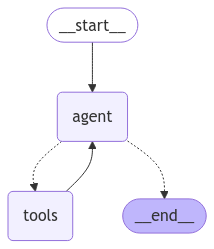

In [ ]:
from IPython.display import display_png
display_png(app.get_graph().draw_mermaid_png(),raw=True)

In [ ]:
import time
while True:
    theinput = input("Enter something: ")
    if 'exit' in theinput:
        break
    inp = {"messages":[theinput]}
    
    config = {"configurable": {"thread_id": 1}}
    events = app.stream(inp, config=config, stream_mode="values")

    for event in events:
        event["messages"][-1].pretty_print()
    time.sleep(1)

================================ Human Message =================================

hello
================================== Ai Message ==================================

I'm here to help. Is there something I can help you with, or would you like to query the Enron emails using the ragtool function?
================================ Human Message =================================

yes i want to know what enron emails convey the info about california energy crisis
================================== Ai Message ==================================
Tool Calls:
  ragtool (call_dqw3)
 Call ID: call_dqw3
  Args:
    query: California energy crisis Enron emails
================================= Tool Message =================================
Name: ragtool

Here is the ANSWER. 
 ```The California energy crisis, as discussed in the Enron emails, appears to be a complex issue involving various stakeholders, including power plants, utilities, and regulatory bodies. The emails suggest that the crisis wa

In [ ]:
# from typing import Literal, List
# from langchain_core.runnables.history import RunnableWithMessageHistory
# from langgraph.graph import StateGraph, START, END, MessagesState
# from langgraph.checkpoint.memory import MemorySaver
# from langchain.memory import ChatMessageHistory
# from langchain_core.chat_history import BaseChatMessageHistory, InMemoryChatMessageHistory
# from langgraph.prebuilt import ToolNode
# from langchain_core.documents import Document
# from langchain_core.tools import tool
# from langchain.chat_models import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate

# # === Define Custom Tools ===


# @tool
# def filter_emails_by_keyword(emails: List[Document], keywords: List[str]) -> List[Document]:
#     """Filter emails that contain the given keywords in the content or metadata."""
#     def filter_email(email):
#         content = email.page_content.lower()
#         metadata = " ".join(str(val).lower() for val in email.metadata.values())
#         return any(keyword.lower() in content or keyword.lower() in metadata for keyword in keywords)
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(lambda e: e if filter_email(e) else None, emails)))

#     return filtered_emails

# @tool
# def filter_emails_by_metadata(
#     emails: List[Document], sender: str = None, recipient: str = None, date: str = None
# ) -> List[Document]:
#     """Filter emails by metadata fields like sender, recipient, or date."""
#     def filter_email(email):
#         if sender and email.metadata.get("sender", "").lower() != sender.lower():
#             return None
#         if recipient and recipient.lower() not in email.metadata.get("recipient", "").lower():
#             return None
#         if date and date not in email.metadata.get("date", ""):
#             return None
#         return email
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(filter_email, emails)))
    
#     return filtered_emails

# @tool
# def summarize_emails(emails: List[Document]) -> List[Document]:
#     """Summarize emails before adding them to FAISS."""
#     _,llm = init_groq(model_name="llama-3.3-70b-versatile")
#     prompt = ChatPromptTemplate.from_template("Summarize the following email:\n{email}")
#     summarized_docs = []
#     for email in emails:
#         chain = prompt | llm
#         summary = chain.invoke(email.page_content)
#         summarized_docs.append(Document(page_content=summary.content, metadata=email.metadata))
#     return summarized_docs

# toolnode = ToolNode([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])
# llm_with_tool = llm.bind_tools([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])

# # === Define Model Function ===
# def call_model(state: MessagesState):
#     """Modify agent behavior to apply filtering and summarization before RAG."""
#     messages = state["messages"]
#     query = messages[-1]

#     # Step 1: Apply Keyword Filtering
#     filtered_emails = filter_emails_by_keyword.invoke({"emails": docslist, "keywords": [query.content]})

#     # Step 2: Apply Metadata Filtering
#     filtered_emails = filter_emails_by_metadata.invoke(
#         {"emails": filtered_emails, "sender": "", "recipient": "", "date": ""}
#     )

#     # Step 3: Summarize Emails if Needed
#     summarized_emails = summarize_emails.invoke({"emails": filtered_emails})

#     # Step 4: Run RAG Tool on Filtered Emails
#     state["messages"].append("\n")
#     response = llm_with_tool.invoke([summarized_emails])

#     return {"messages": [response]}

# # === Define Router Function ===
# def router_function(state: MessagesState) -> Literal["tools", END]:
#     messages = state["messages"]
#     last_message = messages[-1]
#     if last_message.tool_calls:
#         return "tools"
#     return END

# # === Build LangGraph Workflow ===
# memory = MemorySaver()
# workflow = StateGraph(MessagesState)
# workflow.add_node("agent", call_model)
# workflow.add_node(toolnode)
# workflow.add_edge(START, "agent")
# workflow.add_conditional_edges(
#     "agent",
#     router_function,
#     {
#         "tools": "tools",
#         END: END,
#     },
# )
# workflow.add_edge("tools", "agent")
# app = workflow.compile(checkpointer=memory)

# while True:
#     theinput = input("Enter something: ")
#     if 'exit' in theinput:
#         break
#     inp = {"messages":[theinput]}

#     config = {"configurable": {"thread_id": 1}}
#     events = app.stream(inp, config=config, stream_mode="values")

#     for event in events:
#         event["messages"][-1].pretty_print()
